# Generation of simulated HAADF STEM images and multi-elements label maps of High Hentropy Alloys column heights

In this notebook it is demonstrated how to create simulated HAADF STEM images and the corresponding multi-elements labels maps for training a neural network to predict the atomic column heights (CHs) in multi-components high-entropy alloys (HEAs). The Python classes used to derive the HEAs data are implemented in the file 'make_random_HEA_util'. In particular, we will use the following classes:

 
 - **Random_HEA**: generation of random equiatomic PtNiPdCoFe HEAs model with random positions of the five elements in the structure. The random HEAs models are built on top of the precomputed random nanoparticle models generated using the Random_Cluster class.
 
 
 - **HEA_STEM**: generation of the simulated HAADF STEM images from the precomputed HEA atomic models.
 
 
 - **HEA_Labels**: generation of the label maps of the CHs for each chemical element from the precomputed HEA atomic models.
 
 
 - **HEA_Data**: saving the generated data (HEA model, simulated HAADF STEM images and CHs maps) into numpy files.


We mainly use the following Python libraries: **Numpy**, **Scikit-Image** for image processing, **Atomic Simulation Environment (ASE)** for atomistic modeling and **PyQSTEM** for STEM images simulations.

In [33]:
# Importing the libraries

import numpy as np

from make_HEA_data_utils import Random_HEA, HEA_STEM, HEA_Labels, HEA_Data

from ase.visualize import view

from pyqstem import PyQSTEM

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

## HEA atomic models

The class **Random_HEA** is used to generate the atomic models of HEA characterized by an equimolar proportion of five chemical elements: Pt, Ni, Pd, Co and Fe. The HEA models are built using appropriate modules of the **ASE** library. The input parameters are:

 - **crystal_structure**: crystal structure of the HEA atomic model. In this application, we consider FCC solid solutions HEAs. 
 
 
 - **random_size**: we generate HEA with a random size, selected in a range in agreement with the HEAs in the experimental images. In this way, the neural network will be trained on images representing HEAs with the same size of the experimental measurements. For our application, we consider a range between 65 and 75 A. It should be noted that the bigger the HEAs, the higher the computational effort. For an HEA sized between 65 and 75 A, the simulation takes few minutes. Smaller sizes could be considered to try running the code.
 
 
 - **spatial domain**: it is very important to train the neural network on images wich represent a physical domain with the same size of the experimental measurements, unless the applications of the network on experimental images will not work. In our applications, the represented spatial domain is 51.2 A.
 
 
 - **chemical_symbols**: chemical symbols of the elememts in the HEA structure. In our application we consider Pt,Ni,Pd,Co and Fe. The HEA models will be created with a random distribution of the five elements in the structure.

In [2]:
# defining the input parameters

crystal_structure = 'fcc'

random_size = np.random.uniform(15,20,1)[0] #A

spatial_domain = (51.2, 51.2) #A

chemical_symbols = ['Pt','Ni','Pd','Co','Fe']

# creating the object random_HEA of the class Random_HEA

random_HEA = Random_HEA(crystal_structure, random_size, spatial_domain, chemical_symbols)

# generating the HEA model using the method 'get_model' of the Random_HEA class
    
random_HEA_model = random_HEA.get_model() 

/Users/marcoragone-macbookpro/Desktop/HEA-GitHub/make_random_HEA_utils.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.active_bonds = np.array([self.active[b] for b in self.bonds])


In [4]:
view(random_HEA_model)

We can check some properties of the HEA model. For example:

- **chemical composition**:

In [5]:
random_HEA_model.get_chemical_formula()

'Co116Fe114Ni97Pd110Pt95'

- **atomic numbers** and **masses** of the constituents (given in alphabetic order Co, Fe, Ni, Pd, Pt):

In [6]:
print('atomic numbers: {}'.format(np.unique(random_HEA_model.get_atomic_numbers())))
print('')
print('masses: {}'.format(np.unique(random_HEA_model.get_masses())))

atomic numbers: [26 27 28 46 78]

masses: [ 55.845     58.6934    58.933194 106.42     195.084   ]


## Simulated HAADF STEM images

The class **HEA_STEM** is used to generate the simulated HAADF STEM images using the multislice algorithm implemented in the PyQSTEM library. The input parameters are:

- **qstem**: object of the class PyQSTEM in STEM mode. The qstem object contains all the modules necessary to simulate the HAADF STEM images.


- **random_HEA_model**: atomic model of the random HEA structure generated by the Random_HEA class.


- **image_size**: size of the simulated images. We consider 256 x 256 images. The experimental images are 512 x 512, but setting correctly the resolution allows to represent the same spatial domain of 51.2 x 51.2 A.


- **resolution**: amount of A represented in 1 pixel [A/px]. The resolution is equal to the spatial_domain [A] divided by the size of the image [px]. Since we have a spatial domain of 51.2 x 51.2 A and an image size of 256 x 256 px, the resolution is 51.2 A/256 px = 0.2 A/px. The experimental images are 512x512 px, thus the resolution over a spatial domain of 51.2 A is 0.1 A/px. It is essential to generate simulated images with a resolution which is scaled to image size, in order to preserve the same spatial dimensionality.



- **probe**: size of the probe. We consider 8 nm (80 A) in agreement with the expetimental measurements.


- **slice_thickness**: slice thickness in the STEM simulations. We found that a slice thickness of 0.2 nm (2 A) is sufficiently refined for a probe size of 8 nm (80 A). The resulting number of slices is 40.

**Microscope Parameters**: STEM microscope parameters, randomly picked in a range in agreement with the experimental conditions.

- **random_v0**: acceleration voltage [keV].


- **random_alpha**:  convergence_angle [mrad].


- **random_defocus**:  defocus [A].


- **random_Cs**:  1st order aberration.


- **random_asti_mag**: astigmation magnitude [A].


- **random_asti_angle**: astigmation angle [A].

Experimental images are typically affected by a certain degree of noise. We add some random noise with the following parameters:


- **add_noise**: True (or False). Whether or not adding noise to the simulated image.


- **noise_mean**: the noise is created using a random Gaussian distirbution with mean noise_mean.


- **noise_std**: the noise is created using a random Gaussian distirbution with standard deviation noise_std.

In [7]:
# defining the input parameters

qstem = PyQSTEM('STEM')

image_size = (256,256) # px

resolution = spatial_domain[0]/image_size[0]  # [A/px]

probe = 8 # probe size [nm]
    
slice_thickness = 0.2 # [nm]
    
random_v0 = np.random.randint(180,220,size=1)[0] # acceleration voltage [keV]
    
random_alpha = np.random.randint(15,20,size=1)[0] # convergence_angle [mrad]
    
random_defocus = np.random.randint(-10,10,size=1)[0] # defocus [A]
    
random_Cs = np.random.randint(180,220,size=1)[0] # 1st order aberration
    
random_asti_mag = np.random.randint(18,22,size=1)[0] # astigmation magnitude [A]
    
random_asti_angle = np.random.randint(12,16,size=1)[0] # astigmation angle [A]

add_noise = False # depending if we want to add noise in the simulated STEM image

noise_mean = 0.0 # noise distribution mean (noise added is add_noise = True)

noise_std = 1.0  # noise distribution std (noise added is add_noise = True)

In [9]:
# creating the object HEA_stem of the class HEA_STEM

HEA_stem = HEA_STEM(qstem,
                    random_HEA_model, 
                    image_size,
                    resolution, 
                    probe,
                    slice_thickness, 
                    random_v0, 
                    random_alpha, 
                    random_defocus,
                    random_Cs,
                    random_asti_mag,
                    random_asti_angle,
                    add_noise,
                    noise_mean,
                    noise_std)

# generating the simulated HAADF STEM image using the 'get_HEA_stem' method

img = HEA_stem.get_HEA_stem()

## Column Heights Labels

The class **HEA_Labels** is used to generated the column heights maps for each chemical element in the HEA structure. The CHs maps are created with a Gaussian distribution centered in the column's peaks and decreasing with continuity towards the background. The continuity of the pixel's values is essential for the implementation of a regression-based prediction of the CHs.


A label map is created for each chemical element in the HEA structure. Thus, we have five label maps for Pt,Ni,Pd,Co and Fe. The input parameters are:


 - **random_HEA_model**: HEA atomic model generated with the Random_HEA class.
 
 
 - **image_size**: the size of the label maps must be the same of the input image, since the deep learning model is a fully convolutional network (FCN) with a symmetrical structure of the encoder and decoder blocks.
 
 
 - **resolution**: the label maps must be created with the same resolution of the input image in order to preserve the represented spatial dimensionality.



In [25]:
# creating the object HEA_labels of the class HEA_Labels

HEA_labels = HEA_Labels(random_HEA_model,
                        image_size,
                        resolution)

# generating the CHs label maps for each chemical element
lbl = HEA_labels.get_labels_multi_elements()

## Plots of the simulated HAADF STEM image and label maps|

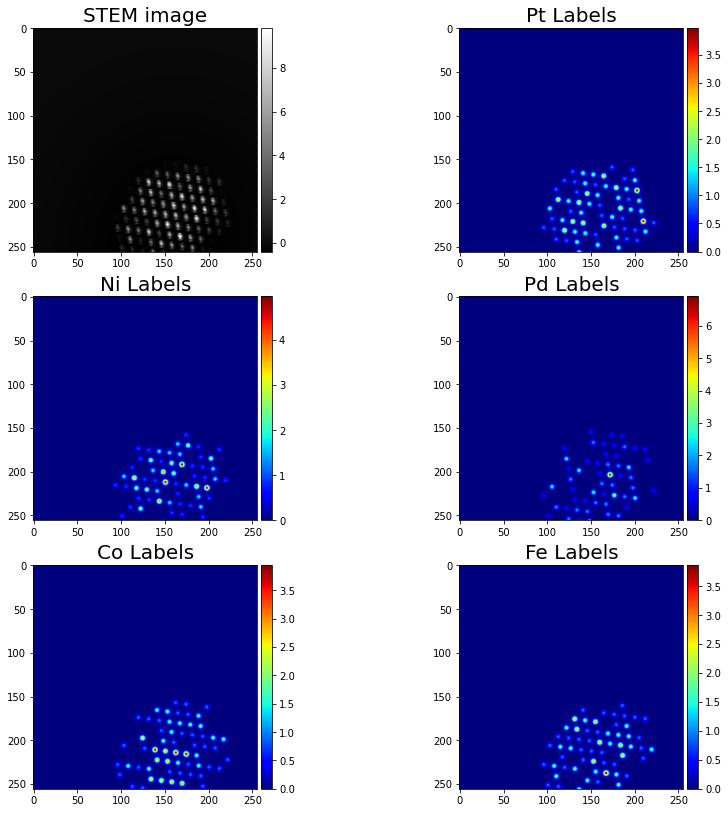

In [28]:
chemical_symbols = ['Pt','Ni','Pd','Co','Fe']

fig = plt.figure(figsize=(14, 14))

ax = fig.add_subplot(3, 2, 1)
im = ax.imshow(img, cmap='gray')
plt.title('STEM image', fontsize=20)
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax1)

for cs in range(1,len(chemical_symbols) + 1):

    ax = fig.add_subplot(3, 2, cs + 1)
    im = ax.imshow(lbl[:, :, cs - 1], cmap='jet')
    plt.title('{} Labels'.format(chemical_symbols[cs - 1]), fontsize=20)
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax1)



## Saving the data

The class **HEA_Data** is used to save the simulated data (i.e., simulated HAADF STEM image and CHs label maps) into a training/test directory. Since the input image and the label maps have the same size, **they are concatenated into a single variable and saved into a single and multi-channel numpy array (tensor) and labeled with the index **data_index**. The input parameters are:


- **random_HEA_model**: HEA atomic model generated with the Random_HEA class.


- **img**: simulated HAADF STEM image.


- **lbl**: CHs label maps.


- **path**: path to the parent directory containing the saved files. The sub-directories will be:

  - **data**: directory containing the tensor data saved in the numpy files (.npy).
  
  - **models**: directory containing the saved atomic models of HEAs (.xyz).
  
  - **plots**: directory containing the plots of the simulated HAADF STEM image and the Pt CHs label map.

In [32]:
# defining the input parameters.

path = 'training_data/' # training data directory.
#path = 'test_data/' # test data direcotry.


data_index = 1 # here we have only 1 data to save.

# creating the object HEA_data of the class HEA_Data.
HEA_data = HEA_Data(random_HEA_model,
                    img,
                    lbl,
                    path,
                    data_index)

# saving the data using the 'save_HEA' method.
HEA_data.save_HEA()